## DM-34898 and DM-34896

During the AP Performance Sprint in May 2022, we persisted timing metrics for two AP Pipeline runs on the same DC2 dataset. One was with weekly w.2022.21 before we changed anything, and one was with weekly w.2022.22 after we fixed some things, most notably in `CharacterizeImageTask`.

In this notebook, we access timing metric data (as well as the APDB) and make plots to learn how it went!

In [2]:
%matplotlib notebook

import os
import sys
import itertools
import numpy as np
import importlib
import psycopg2
import pandas as pd

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm
import seaborn as sns

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
import lsst.daf.butler as dafButler
import lsst.geom

## Look at original run via w_2022_21

In [3]:
repo = '/repo/dc2'
collections = 'u/mrawls/DM-34828-w_2022_21'
instrument='LSSTCam-imSim'
skymap='DC2'
butler = dafButler.Butler(repo, collections=collections, instrument=instrument, skymap=skymap)
schema = 'mrawls_DM34828_w202221'

In [4]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [4]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3',
                                                                               instrument=instrument,
                                                                               repo=repo)

Plot the DIA Objects on the sky, with point size as a function of how many DIA Sources each one has

There are more sources near the center of the region because that's where the most visits overlap

<IPython.core.display.Javascript object>


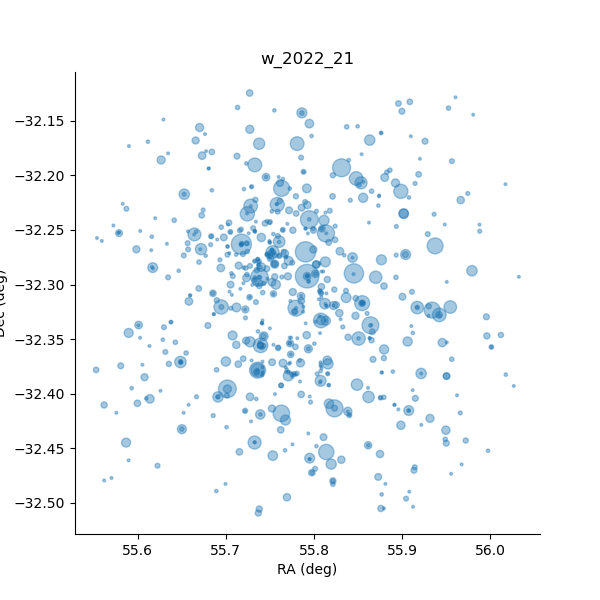

Text(0.5, 1.0, 'w_2022_21')

In [6]:
fig = plt.figure(figsize=(6,6))

cutoff = 1  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'ra'], goodObj.loc[goodObj['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=(goodObj.loc[goodObj['nDiaSources'] > cutoff, 'nDiaSources'])*2, marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('w_2022_21')

### Explore the things in the butler that have time-related names

Hopefully some of them are the task timing metrics we seek

In [1]:
#list(butler.registry.queryDatasetTypes("*Time"))

In [5]:
# Blatantly copied from DM-34865 branch of verify (extract_metrics.py)
# But then we changed everything

query = "*Time"  # for example, `metricvalue_ap_association_DiaPipelineTime` is a butler DatasetType
reject_suffix = None
verbose = False

metrics = butler.registry.queryDatasetTypes(query)
dataIds = butler.registry.queryDataIds(("detector", "visit"), datasets="calexp")
result1 = []
for dataId, metric in itertools.product(dataIds, metrics):
    if reject_suffix is not None and metric.name.endswith(reject_suffix):
        continue
    try:
        value = butler.get(metric, dataId=dataId)
    except LookupError:
        if verbose:
            print(f"{metric.name} not found")
        continue
    #timings = {key: value[0] for (key, value) in value.metadata['quantum'].arrays.items()}
    result1.append({"visit": dataId["visit"], "detector": dataId["detector"], "metric": metric.name,
                   "time": value.quantity.value})

In [9]:
value.quantity  # IT'S A TIME IN SECONDS

<Quantity 2.056027 s>

In [6]:
#result1

In [7]:
timingdf1 = pd.DataFrame(result1)

In [12]:
timingdf1.columns

Index(['visit', 'detector', 'metric', 'time'], dtype='object')

In [13]:
timingdf1

,visit,detector,metric,time
0,252424,2,metricvalue_pipe_tasks_ImageDifferenceTime,87.999671
1,252424,2,metricvalue_ap_association_AssociationTime,0.012772
2,252424,2,metricvalue_ap_association_LoadDiaCatalogsTime,3.995214
3,252424,2,metricvalue_pipe_tasks_CharacterizeImageTime,278.426279
4,252424,2,metricvalue_ip_diffim_DipoleFitTime,2.227042
...,...,...,...,...
3259,974779,188,metricvalue_ip_isr_IsrTime,34.201776
3260,974779,188,metricvalue_ap_association_DiaPipelineTime,3.469481
3261,974779,188,metricvalue_meas_algorithms_SourceDetectionTime,2.616210
3262,974779,188,metricvalue_pipe_tasks_CalibrateTime,38.594162


In [8]:
timingdf1[['metric', 'time']].groupby('metric').agg([np.median, np.std])

time            
                                                     median         std
metric                                                                 
metricvalue_ap_association_AssociationTime         0.011173    0.007658
metricvalue_ap_association_DiaForcedSourceTime     4.113291    4.347943
metricvalue_ap_association_DiaPipelineTime         6.804906    6.848362
metricvalue_ap_association_LoadDiaCatalogsTime     1.236470    1.985475
metricvalue_ap_association_MapDiaSourceTime        0.084212    0.030371
metricvalue_ip_diffim_DipoleFitTime                2.329930    1.658089
metricvalue_ip_diffim_ImagePsfMatchTime           59.514785   33.105361
metricvalue_ip_isr_IsrTime                        33.246151   11.336970
metricvalue_meas_algorithms_SourceDetectionTime    2.465635    0.704575
metricvalue_pipe_tasks_CalibrateTime              52.982698   17.020704
metricvalue_pipe_tasks_CharacterizeImageTime     239.346872  107.716790
metricvalue_pipe_tasks_ImageDifferenceTime        83.044208   36.422618

### Now that we've taken a look at all the timing metrics, let's plot the ones we care about

In [9]:
metricsToPlot = ['metricvalue_ip_isr_IsrTime', 'metricvalue_pipe_tasks_CharacterizeImageTime',
                'metricvalue_pipe_tasks_CalibrateTime', 'metricvalue_pipe_tasks_ImageDifferenceTime',
                'metricvalue_ip_diffim_ImagePsfMatchTime', 'metricvalue_ap_association_DiaPipelineTime',
                'metricvalue_ap_association_DiaForcedSourceTime']
len(metricsToPlot)

7

In [10]:
taskTiming1 = {}
for metric in metricsToPlot:
    taskTiming1[metric] = timingdf1.loc[timingdf1['metric'] == metric]

<IPython.core.display.Javascript object>


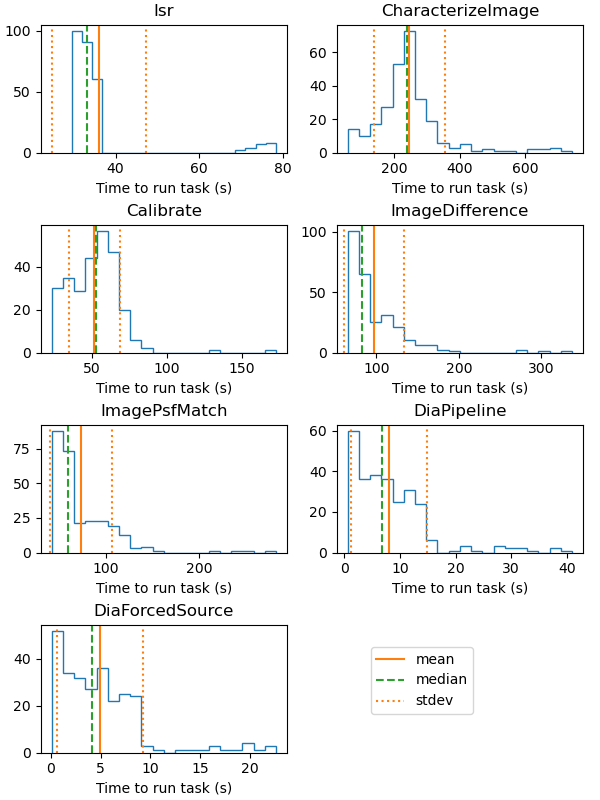

In [17]:
fig = plt.figure(figsize=(6,8), constrained_layout=True)
for idx, metric in enumerate(taskTiming1):
    mean = np.mean(taskTiming1[metric].time)
    median = np.median(taskTiming1[metric].time)
    stdev = np.std(taskTiming1[metric].time)
    ax = fig.add_subplot(4,2,idx+1)
    bins = 20
    ax.hist(taskTiming1[metric].time, bins=bins, histtype='step')
    ax.axvline(x=mean, color='C1', label='mean' if idx==0 else '_nolegend_')
    ax.axvline(x=median, color='C2', ls='--', label='median' if idx==0 else '_nolegend_')
    ax.axvline(x=mean+stdev, color='C1', ls=':', label='stdev' if idx==0 else '_nolegend_')
    ax.axvline(x=mean-stdev, color='C1', ls=':')
    ax.set_xlabel('Time to run task (s)')
    ax.set_title(metric.split('_')[-1][:-4])
fig.legend(bbox_to_anchor=(0.8, 0.2))
#plt.subplots_adjust(hspace=0.7, wspace=0.1)

### DiaPipeline is where all the source association happens

It would be nice to see if the time to run this tasks increases as the DIA Source history gets longer. However, since bps inherently parallelizes everything, there's no fixed order for the visits to process in, so we'll have to dig deeper to make an instructive plot.

<IPython.core.display.Javascript object>


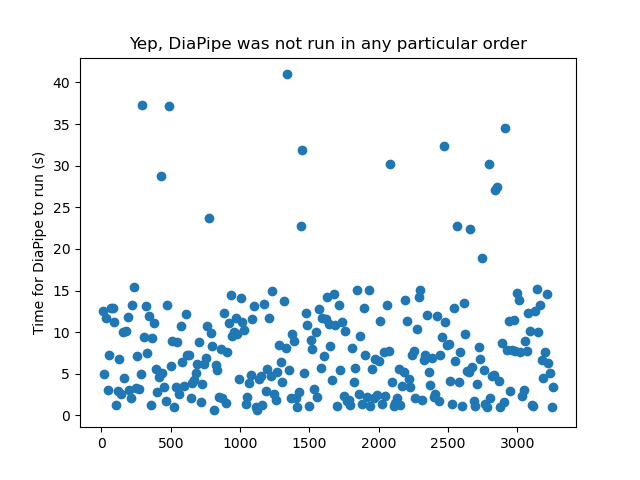

Text(0, 0.5, 'Time for DiaPipe to run (s)')

In [60]:
plt.figure()
plt.plot(taskTiming1['metricvalue_ap_association_DiaPipelineTime'].time, ls='None', marker='o')
plt.title("Yep, DiaPipe was not run in any particular order")
plt.ylabel('Time for DiaPipe to run (s)')

## Look at new run with extraneous tasks removed (DM-34826) via w_2022_22

Basically repeating all the above, but using clever new names like `butler2` and `results2` throughout

In [73]:
#repo = '/repo/dc2'
collections2 = 'u/mrawls/DM-34828-w_2022_22'
#instrument='LSSTCam-imSim'
#skymap='DC2'
butler2 = dafButler.Butler(repo, collections=collections2, instrument=instrument, skymap=skymap)
schema2 = 'mrawls_DM34828_w202222'

In [74]:
objTable2, srcTable2, goodObj2, goodSrc2 = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName='lsstdevapdb1',
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument=instrument,
                                                          badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.1/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [75]:
srcTable2 = pla.addVisitCcdToSrcTable(srcTable2, instrument=instrument, gen='gen3', butler=butler2)
flagTable2, srcTableFlags2, flagFilter2, goodSrc2, goodObj2 = pla.makeSrcTableFlags(srcTable2, objTable2,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3',
                                                                               instrument=instrument,
                                                                               repo=repo)

<IPython.core.display.Javascript object>


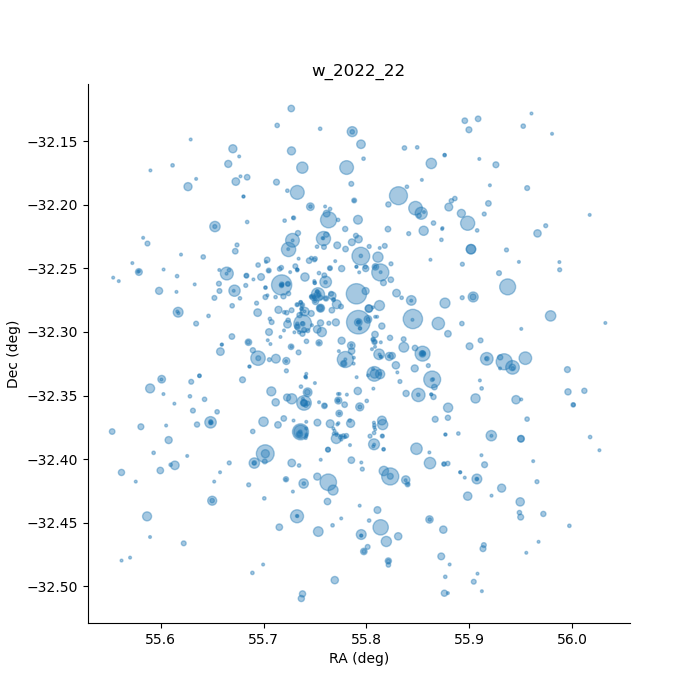

Text(0.5, 1.0, 'w_2022_22')

In [79]:
fig = plt.figure(figsize=(7,7))

cutoff = 1  # only plot DIA Objects composed of cutoff or more DIA Sources

ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'ra'], goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'decl'], 
           c='C0', s=(goodObj2.loc[goodObj2['nDiaSources'] > cutoff, 'nDiaSources'])*2, marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('w_2022_22')

In [14]:
query = "*Time"  # for example, `metricvalue_ap_association_DiaPipelineTime` is a butler DatasetType
reject_suffix = None
verbose = False

metrics = butler2.registry.queryDatasetTypes(query)
dataIds = butler2.registry.queryDataIds(("detector", "visit"), datasets="calexp")
result2 = []
for dataId, metric in itertools.product(dataIds, metrics):
    if reject_suffix is not None and metric.name.endswith(reject_suffix):
        continue
    try:
        value = butler2.get(metric, dataId=dataId)
    except LookupError:
        if verbose:
            print(f"{metric.name} not found")
        continue
    #timings = {key: value[0] for (key, value) in value.metadata['quantum'].arrays.items()}
    result2.append({"visit": dataId["visit"], "detector": dataId["detector"], "metric": metric.name,
                   "time": value.quantity.value})

In [15]:
timingdf2 = pd.DataFrame(result2)

In [16]:
timingdf2[['metric', 'time']].groupby('metric').agg([np.median, np.std])

time           
                                                    median        std
metric                                                               
metricvalue_ap_association_AssociationTime        0.010714   0.005306
metricvalue_ap_association_DiaForcedSourceTime    4.058446   3.821895
metricvalue_ap_association_DiaPipelineTime        6.508351   5.941151
metricvalue_ap_association_LoadDiaCatalogsTime    1.038602   1.756881
metricvalue_ap_association_MapDiaSourceTime       0.242555   0.072481
metricvalue_ip_diffim_DipoleFitTime               2.514915   1.748772
metricvalue_ip_diffim_ImagePsfMatchTime          59.508144  32.793649
metricvalue_ip_isr_IsrTime                       33.725039  10.145609
metricvalue_meas_algorithms_SourceDetectionTime   2.497402   0.641882
metricvalue_pipe_tasks_CalibrateTime             46.375650  22.139552
metricvalue_pipe_tasks_CharacterizeImageTime     70.165447  29.152848
metricvalue_pipe_tasks_ImageDifferenceTime       83.351056  35.501772

In [17]:
taskTiming2 = {}
for metric in metricsToPlot:
    taskTiming2[metric] = timingdf2.loc[timingdf2['metric'] == metric]

<IPython.core.display.Javascript object>


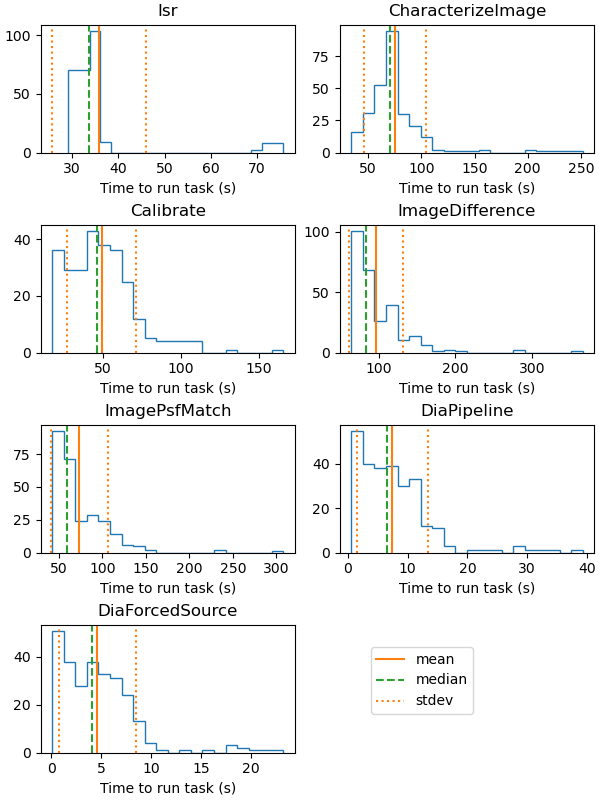

In [27]:
fig = plt.figure(figsize=(6,8), constrained_layout=True)
for idx, metric in enumerate(taskTiming2):
    mean = np.mean(taskTiming2[metric].time)
    median = np.median(taskTiming2[metric].time)
    stdev = np.std(taskTiming2[metric].time)
    ax = fig.add_subplot(4,2,idx+1)
    bins = 20
    ax.hist(taskTiming2[metric].time, bins=bins, histtype='step')
    ax.axvline(x=mean, color='C1', label='mean' if idx==0 else '_nolegend_')
    ax.axvline(x=median, color='C2', ls='--', label='median' if idx==0 else '_nolegend_')
    ax.axvline(x=mean+stdev, color='C1', ls=':', label='stdev' if idx==0 else '_nolegend_')
    ax.axvline(x=mean-stdev, color='C1', ls=':')
    ax.set_xlabel('Time to run task (s)')
    ax.set_title(metric.split('_')[-1][:-4])
fig.legend(bbox_to_anchor=(0.8, 0.2))

## Overplot run1 vs run2

Now that we have two runs, let's make a plot to compare them

In [18]:
def plotOneRun(axes, taskTiming):
    for ax, metric in zip(axes.flatten(), taskTiming):
        mean = np.mean(taskTiming[metric].time)
        median = np.median(taskTiming[metric].time)
        stdev = np.std(taskTiming[metric].time)
        bins = 20
        ax.hist(taskTiming[metric].time, bins=bins, histtype='step')
        #ax.axvline(x=mean, color='C1', label='mean' if idx==0 else '_nolegend_')
        #ax.axvline(x=median, color='C2', ls='--', label='median' if idx==0 else '_nolegend_')
        #ax.axvline(x=mean+stdev, color='C1', ls=':', label='stdev' if idx==0 else '_nolegend_')
        #ax.axvline(x=mean-stdev, color='C1', ls=':')
        ax.set_xlabel('Time to run task (s)')
        ax.set_title(metric.split('_')[-1][:-4])

<IPython.core.display.Javascript object>


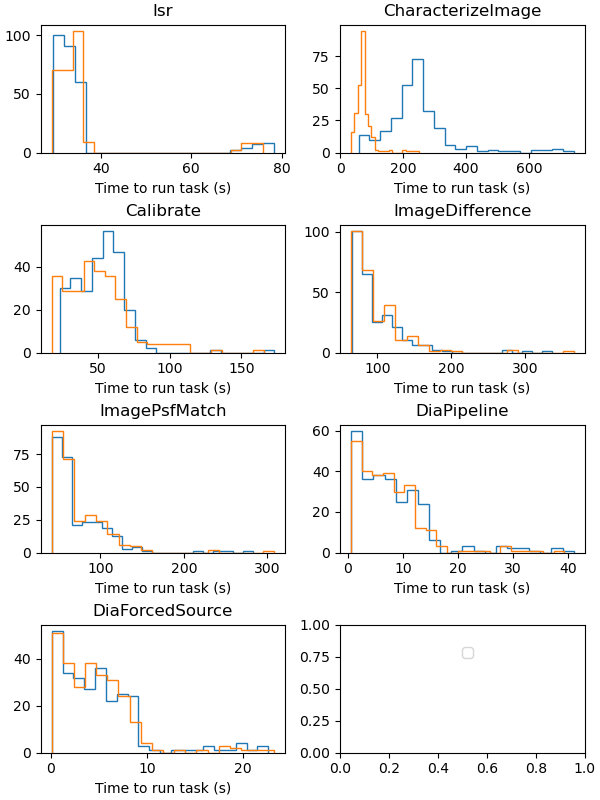

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(6,8), constrained_layout=True)
#print(axes)
plotOneRun(axes, taskTiming1)
plotOneRun(axes, taskTiming2)
fig.legend(bbox_to_anchor=(0.8, 0.2))

## Access metadata for figuring out visit process order

Going back now to the DiaPipeline situation... we would like to investigate how DiaPipeTask slows over time as the DIA Source history grows. To do this, we'll use differently-named butler dataset timing metrics that break down how long each part of a task takes.

In [20]:
metrics = list(butler.registry.queryDatasetTypes("timing*"))
#metrics

In [21]:
query = "timing_diaPipe_metadata"
reject_suffix = None
verbose = False

metrics = butler.registry.queryDatasetTypes(query)
dataIds = butler.registry.queryDataIds(("detector", "visit"), datasets="calexp")
result = []
for dataId, metric in itertools.product(dataIds, metrics):
    if reject_suffix is not None and metric.name.endswith(reject_suffix):
        continue
    try:
        value = butler.get(metric, dataId=dataId)
    except LookupError:
        if verbose:
            print(f"{metric.name} not found")
        continue
    timings = {key: value[0] for (key, value) in value.metadata['quantum'].arrays.items()}
    result.append({"visit": dataId["visit"], "detector": dataId["detector"], "metric": metric.name,
                   **timings})

In [22]:
# we want to keep track of visit, detector, and endUtc from result
df = pd.DataFrame(result)

In [23]:
df[['visit', 'detector', 'endUtc']]

,visit,detector,endUtc
0,252424,2,2022-05-26T19:39:59.446994
1,475692,3,2022-05-26T19:38:11.862105
2,479254,3,2022-05-26T19:39:46.602449
3,938249,3,2022-05-26T19:36:20.820848
4,420782,5,2022-05-26T19:38:50.696489
...,...,...,...
267,693404,187,2022-05-26T19:48:50.442158
268,1229644,187,2022-05-26T19:38:27.476213
269,425492,188,2022-05-26T19:37:57.338180
270,914675,188,2022-05-26T19:32:31.200968


Let's get that time in a somewhat more useful format

In [25]:
endUtc_astropy = {}
for idx, row in df.iterrows():
    endUtc_astropy[idx] = Time(row['endUtc']).mjd

In [26]:
df['endMjd'] = pd.Series(endUtc_astropy)

In [27]:
df[['visit', 'detector', 'endMjd']]

,visit,detector,endMjd
0,252424,2,59725.819438
1,475692,3,59725.818193
2,479254,3,59725.819289
3,938249,3,59725.816908
4,420782,5,59725.818642
...,...,...,...
267,693404,187,59725.825584
268,1229644,187,59725.818374
269,425492,188,59725.818025
270,914675,188,59725.814250


Next, use the DiaPipe info only from our previous `timingdf1` dataframe to pull out the total task time, and merge it with the more granular timings above, so we now have the `endUtc` (or, equivalently, `endMjd`) data to order the visits by

In [38]:
diaPipe1 = timingdf1.loc[timingdf1['metric'] == 'metricvalue_ap_association_DiaPipelineTime']

In [39]:
diaPipe1

,visit,detector,metric,time
8,252424,2,metricvalue_ap_association_DiaPipelineTime,12.532411
20,475692,3,metricvalue_ap_association_DiaPipelineTime,5.035033
32,479254,3,metricvalue_ap_association_DiaPipelineTime,11.761076
44,938249,3,metricvalue_ap_association_DiaPipelineTime,3.032726
56,420782,5,metricvalue_ap_association_DiaPipelineTime,7.287099
...,...,...,...,...
3212,693404,187,metricvalue_ap_association_DiaPipelineTime,14.595940
3224,1229644,187,metricvalue_ap_association_DiaPipelineTime,6.350372
3236,425492,188,metricvalue_ap_association_DiaPipelineTime,5.101126
3248,914675,188,metricvalue_ap_association_DiaPipelineTime,1.070732


In [40]:
diaPipeOrder1 = pd.merge(df, diaPipe1, on=['visit', 'detector'])[['visit', 'detector', 'time', 'endMjd']]

In [41]:
diaPipeOrder1

,visit,detector,time,endMjd
0,252424,2,12.532411,59725.819438
1,475692,3,5.035033,59725.818193
2,479254,3,11.761076,59725.819289
3,938249,3,3.032726,59725.816908
4,420782,5,7.287099,59725.818642
...,...,...,...,...
267,693404,187,14.595940,59725.825584
268,1229644,187,6.350372,59725.818374
269,425492,188,5.101126,59725.818025
270,914675,188,1.070732,59725.814250


### Plot how long each instance of DiaPipeTask took versus the timestamp when DiaPipeTask ended

We can further color-code the points by visit number or by detector number to see if there are any weird correlations there (spoiler: there aren't)

<IPython.core.display.Javascript object>


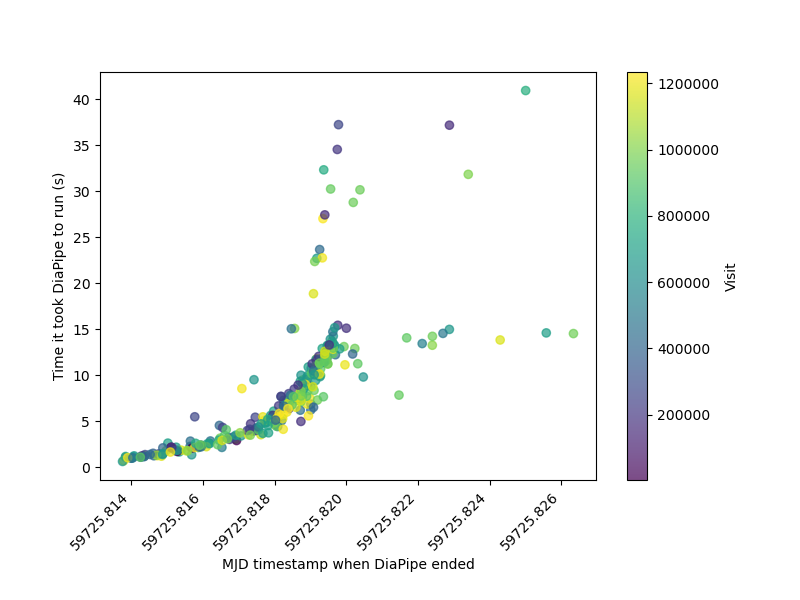

In [47]:
fig = plt.figure(figsize=(8,6))
plt.scatter(diaPipeOrder1['endMjd'], diaPipeOrder1['time'], c=diaPipeOrder1['visit'], alpha=0.7)
plt.colorbar(format='%.0d', label='Visit')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('MJD timestamp when DiaPipe ended')
plt.ylabel('Time it took DiaPipe to run (s)')
fig.autofmt_xdate(rotation=45)

<IPython.core.display.Javascript object>


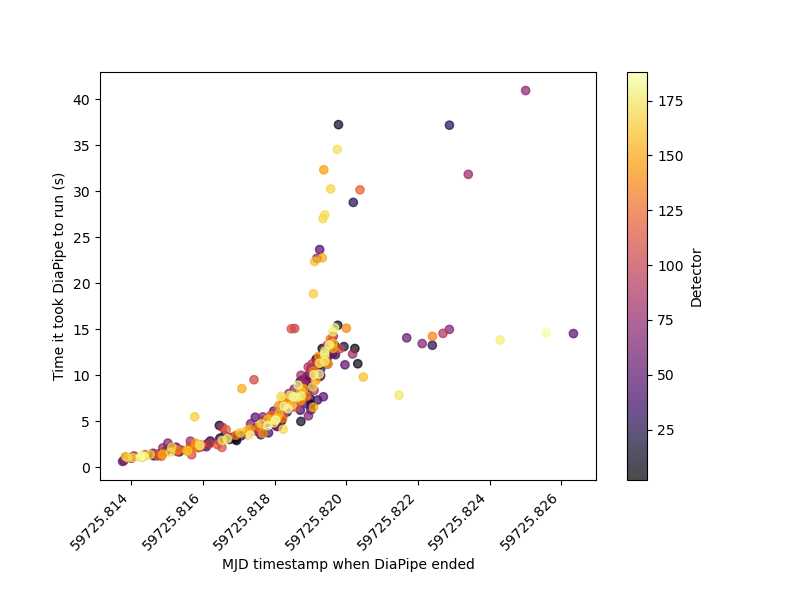

In [51]:
fig = plt.figure(figsize=(8,6))
plt.scatter(diaPipeOrder1['endMjd'], diaPipeOrder1['time'], c=diaPipeOrder1['detector'], alpha=0.7, cmap='inferno')
plt.colorbar(format='%.0d', label='Detector')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('MJD timestamp when DiaPipe ended')
plt.ylabel('Time it took DiaPipe to run (s)')
fig.autofmt_xdate(rotation=45)

## Repeat the above for weekly 22

Exactly what it says on the tin

In [42]:
query = "timing_diaPipe_metadata"
reject_suffix = None
verbose = False

metrics = butler2.registry.queryDatasetTypes(query)
dataIds = butler2.registry.queryDataIds(("detector", "visit"), datasets="calexp")
result22 = []
for dataId, metric in itertools.product(dataIds, metrics):
    if reject_suffix is not None and metric.name.endswith(reject_suffix):
        continue
    try:
        value = butler2.get(metric, dataId=dataId)
    except LookupError:
        if verbose:
            print(f"{metric.name} not found")
        continue
    timings = {key: value[0] for (key, value) in value.metadata['quantum'].arrays.items()}
    result22.append({"visit": dataId["visit"], "detector": dataId["detector"], "metric": metric.name,
                   **timings})

In [43]:
df22 = pd.DataFrame(result22)

In [44]:
endUtc_astropy22 = {}
for idx, row in df22.iterrows():
    endUtc_astropy22[idx] = Time(row['endUtc']).mjd
df22['endMjd'] = pd.Series(endUtc_astropy22)

In [45]:
diaPipe2 = timingdf2.loc[timingdf2['metric'] == 'metricvalue_ap_association_DiaPipelineTime']

In [46]:
diaPipeOrder2 = pd.merge(df22, diaPipe2, on=['visit', 'detector'])[['visit', 'detector', 'time', 'endMjd']]

<IPython.core.display.Javascript object>


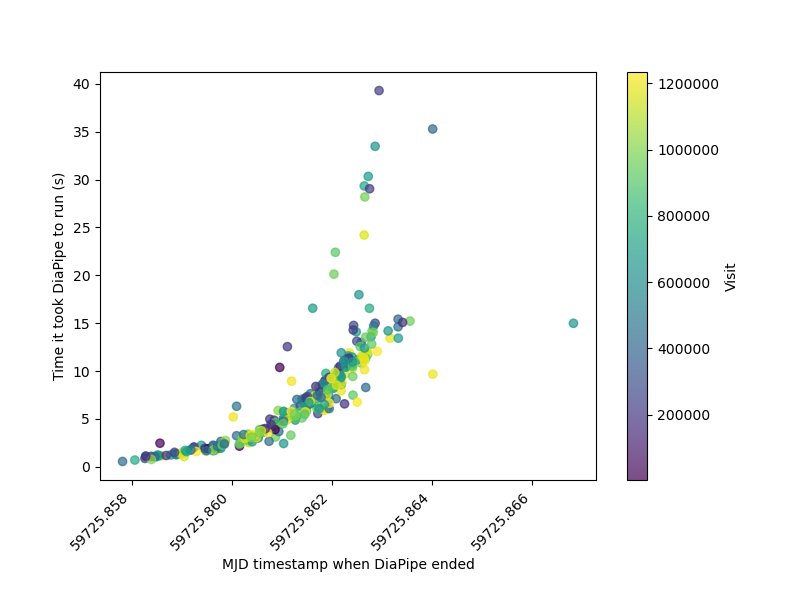

In [48]:
fig = plt.figure(figsize=(8,6))
plt.scatter(diaPipeOrder2['endMjd'], diaPipeOrder2['time'], c=diaPipeOrder2['visit'], alpha=0.7)
plt.colorbar(format='%.0d', label='Visit')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('MJD timestamp when DiaPipe ended')
plt.ylabel('Time it took DiaPipe to run (s)')
fig.autofmt_xdate(rotation=45)

<IPython.core.display.Javascript object>


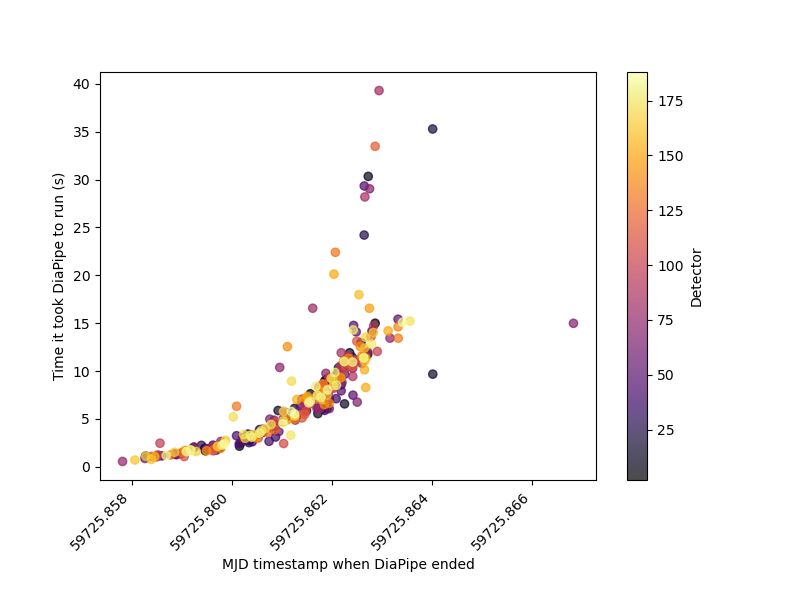

In [49]:
fig = plt.figure(figsize=(8,6))
plt.scatter(diaPipeOrder2['endMjd'], diaPipeOrder2['time'], c=diaPipeOrder2['detector'], alpha=0.7, cmap='inferno')
plt.colorbar(format='%.0d', label='Detector')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('MJD timestamp when DiaPipe ended')
plt.ylabel('Time it took DiaPipe to run (s)')
fig.autofmt_xdate(rotation=45)

In [52]:
# TODO: investigate the total number of DiaObjects that exist at each x-axis timestamp

In [47]:
diaPipeOrder2

,visit,detector,time,endMjd
0,252424,2,14.995493,59725.862865
1,475692,3,5.172711,59725.861287
2,479254,3,7.637476,59725.861573
3,938249,3,2.001625,59725.859766
4,420782,5,8.350489,59725.862019
...,...,...,...,...
266,693404,187,6.687388,59725.861541
267,1229644,187,5.783494,59725.861189
268,425492,188,2.398588,59725.859855
269,914675,188,4.495697,59725.861025


### Plot metadata timings for each portion of DiaPipeTask against endMjd

Break it down further! We'll just use w.2022.22 since the DiaPipe timings are basically equivalent between the two runs; we didn't change anything in that part of the code between the two weeklies.

In [33]:
list(butler2.registry.queryDatasetTypes("metricvalue_ap_association*Time"))

[DatasetType('metricvalue_ap_association_PackageAlertsTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue),
 DatasetType('metricvalue_ap_association_AssociationTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue),
 DatasetType('metricvalue_ap_association_LoadDiaCatalogsTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue),
 DatasetType('metricvalue_ap_association_MapDiaSourceTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue),
 DatasetType('metricvalue_ap_association_DiaPipelineTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue),
 DatasetType('metricvalue_ap_association_DiaForcedSourceTime', {band, instrument, detector, physical_filter, visit_system, visit}, MetricValue)]

In [35]:
# Maybe we already had this in another pandas dataframe above and I forgot? Oh well

query = "metricvalue_ap_association*Time"
reject_suffix = None
verbose = False

metrics = butler2.registry.queryDatasetTypes(query)
dataIds = butler2.registry.queryDataIds(("detector", "visit"), datasets="calexp")
result_metadata = []
for dataId, metric in itertools.product(dataIds, metrics):
    if reject_suffix is not None and metric.name.endswith(reject_suffix):
        continue
    try:
        value = butler2.get(metric, dataId=dataId)
    except LookupError:
        if verbose:
            print(f"{metric.name} not found")
        continue
    #timings = {key: value[0] for (key, value) in value.metadata['quantum'].arrays.items()}
    result_metadata.append({"visit": dataId["visit"], "detector": dataId["detector"], "metric": metric.name,
                   "time": value.quantity.value})

In [2]:
#result_metadata

In [66]:
associationTimes = []
loadDiaCatalogsTimes = []
#packageAlertsTimes = []
mapDiaSourceTimes = []
diaPipelineTimes = []
diaForcedSourceTimes = []
for item in result_metadata:
    if item['metric'] == 'metricvalue_ap_association_AssociationTime':
        associationTimes.append(item['time'])
    elif item['metric'] == 'metricvalue_ap_association_LoadDiaCatalogsTime':
        loadDiaCatalogsTimes.append(item['time'])
    #elif item['metric'] == 'metricvalue_ap_association_PackageAlertsTime':
    #    packageAlertsTimes.append(item['time'])
    elif item['metric'] == 'metricvalue_ap_association_MapDiaSourceTime':
        mapDiaSourceTimes.append(item['time'])
    elif item['metric'] == 'metricvalue_ap_association_DiaPipelineTime':
        diaPipelineTimes.append(item['time'])
    elif item['metric'] == 'metricvalue_ap_association_DiaForcedSourceTime':
        diaForcedSourceTimes.append(item['time'])

In [65]:
len(packageAlertsTimes)

0

<IPython.core.display.Javascript object>


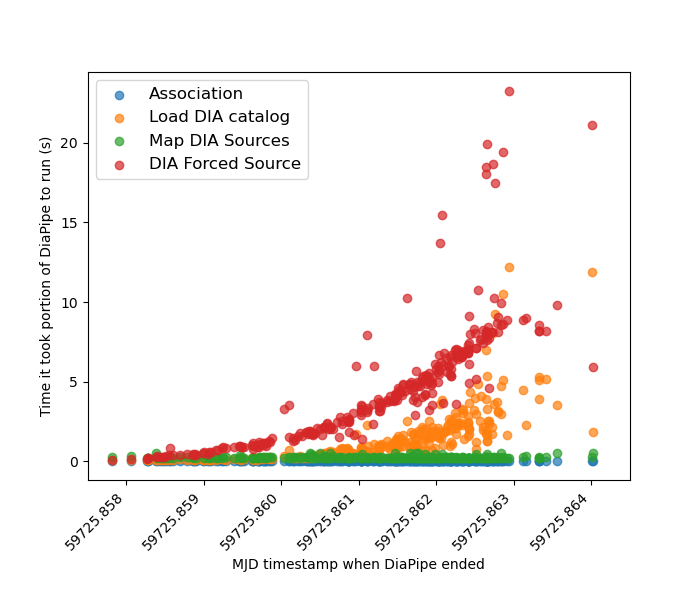

(59725.8575, 59725.8645)

In [89]:
fig = plt.figure(figsize=(7,6))
plt.scatter(diaPipeOrder2['endMjd'], associationTimes, label='Association', alpha=0.7)
plt.scatter(diaPipeOrder2['endMjd'], loadDiaCatalogsTimes, label='Load DIA catalog', alpha=0.7)
plt.scatter(diaPipeOrder2['endMjd'], mapDiaSourceTimes, label='Map DIA Sources', alpha=0.7)
#plt.scatter(diaPipeOrder2['endMjd'], diaPipelineTimes, label='Main DIA Pipeline', alpha=0.7)
plt.scatter(diaPipeOrder2['endMjd'], diaForcedSourceTimes, label='DIA Forced Source', alpha=0.7)
plt.legend(fontsize=12)
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('MJD timestamp when DiaPipe ended')
plt.ylabel('Time it took portion of DiaPipe to run (s)')
fig.autofmt_xdate(rotation=45)
plt.gca().set_xlim(59725.8575, 59725.8645)  # there is one point wayyyyy out to the right that is boring

## Sandbox

An earlier attempt to use APDB validity times to learn how long DiaPipe took to run (incomplete)

In [66]:
objTable2

,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,rPSFluxMean,iPSFluxMean,zPSFluxMean,yPSFluxMean,validityEnd,flags
0,354459390331322417,56.014647,-32.338778,1,NaN,NaN,NaN,NaN,NaN,None,0
1,354459390331322429,55.842132,-32.313292,1,NaN,NaN,NaN,NaN,NaN,None,1
2,354459390331322430,55.825428,-32.312890,1,NaN,NaN,NaN,NaN,NaN,None,1
3,354459390331322431,55.806798,-32.305422,1,NaN,NaN,NaN,NaN,NaN,None,0
4,354459390331322434,55.986553,-32.275901,1,NaN,NaN,NaN,NaN,NaN,None,1
...,...,...,...,...,...,...,...,...,...,...,...
6429,518296815364210956,55.801200,-32.322614,1,NaN,NaN,-1164.977483,NaN,NaN,None,1
6430,518296815364210964,55.905193,-32.393357,1,NaN,NaN,1332.606478,NaN,NaN,None,0
6431,518296815364210968,55.905140,-32.383584,1,NaN,NaN,-1174.430381,NaN,NaN,None,1
6432,518296815364210969,55.820803,-32.306860,1,NaN,NaN,-1358.881337,NaN,NaN,None,1


In [67]:
host = 'lsst-pg-devel1.ncsa.illinois.edu'
dbType = 'postgres'
dbName = 'lsstdevapdb1'
schema = 'mrawls_DM34828_w202222'
connection = psycopg2.connect(dbname=dbName, host=host, options=f'-c search_path={schema}')
objTableAll = pd.read_sql_query('select * from {0};'.format('"DiaObject"'), connection)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.0.0/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [68]:
objTableAll

,diaObjectId,validityStart,validityEnd,ra,raErr,decl,declErr,ra_decl_Cov,radecTai,pmRa,...,yPSFluxMax,yPSFluxStetsonJ,yPSFluxLinearSlope,yPSFluxLinearIntercept,yPSFluxMaxSlope,yPSFluxErrMean,flags,lastNonForcedSource,nDiaSources,pixelId
0,231490724992909349,2023-09-11 05:52:18.038200,NaT,55.713028,None,-32.421816,None,None,60198.244653,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2023-09-11 05:52:18.038200,1,9871189216492
1,231490724992909350,2023-09-11 05:52:18.038200,NaT,55.702050,None,-32.395007,None,None,60198.244653,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2023-09-11 05:52:18.038200,1,9871185905290
2,231490724992909352,2023-09-11 05:52:18.038200,NaT,55.739810,None,-32.419260,None,None,60198.244653,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2023-09-11 05:52:18.038200,1,9871186256224
3,231490724992909355,2023-09-11 05:52:18.038200,NaT,55.813097,None,-32.453148,None,None,60198.244653,None,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2023-09-11 05:52:18.038200,1,9871232024291
4,231490724992909357,2023-09-11 05:52:18.038200,2023-12-01 05:07:33.590200,55.770915,None,-32.379663,None,None,60198.244653,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2023-09-11 05:52:18.038200,1,9871185506716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18050,351363794800214103,2024-08-27 06:33:48.864000,NaT,55.833600,None,-32.432486,None,None,60549.273482,None,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2024-08-27 06:33:48.864000,1,9871232593274
18051,351363794800214105,2024-08-27 06:33:48.864000,NaT,55.832056,None,-32.382657,None,None,60549.273482,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-08-27 06:33:48.864000,1,9871231602666
18052,351363794800214109,2024-08-27 06:33:48.864000,NaT,55.820537,None,-32.381586,None,None,60549.273482,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-08-27 06:33:48.864000,1,9871231579900
18053,351363794800214110,2024-08-27 06:33:48.864000,NaT,55.824855,None,-32.317832,None,None,60549.273482,None,...,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-08-27 06:33:48.864000,1,9875799397671


In [70]:
utc_timestamp = {}
for idx, row in objTableAll.iterrows():
    try:
        utc_timestamp[idx] = Time(row['validityEnd']).mjd
    except:
        utc_timestamp[idx] = np.nan
objTableAll['validityEndMjd'] = pd.Series(utc_timestamp)

In [80]:
objTableAll[objTableAll['validityEndMjd'].notnull()][['diaObjectId', 'validityStart', 'nDiaSources', 'validityEnd', 'validityEndMjd']]#.groupby('validityEndMjd').agg(np.median)

,diaObjectId,validityStart,nDiaSources,validityEnd,validityEndMjd
4,231490724992909357,2023-09-11 05:52:18.038200,1,2023-12-01 05:07:33.590200,60279.213583
12,231490724992909363,2023-09-11 05:52:18.038200,1,2025-01-27 02:15:54.796900,60702.094384
13,231490724992909365,2023-09-11 05:52:18.038200,1,2025-01-27 02:15:54.796900,60702.094384
14,231490724992909368,2023-09-11 05:52:18.038200,1,2025-01-27 02:15:54.796900,60702.094384
15,231490724992909370,2023-09-11 05:52:18.038200,1,2025-01-27 02:15:54.796900,60702.094384
...,...,...,...,...,...
18008,347653985122910312,2023-08-23 08:28:40.041800,62,2024-08-27 06:33:48.864000,60549.273482
18009,369151918326415462,2026-10-30 02:32:53.107100,12,2024-08-27 06:33:48.864000,60549.273482
18010,408158882712518732,2026-10-30 02:32:53.107100,68,2024-08-27 06:33:48.864000,60549.273482
18011,408158882712518755,2022-08-30 06:38:07.027100,138,2024-08-27 06:33:48.864000,60549.273482


<IPython.core.display.Javascript object>


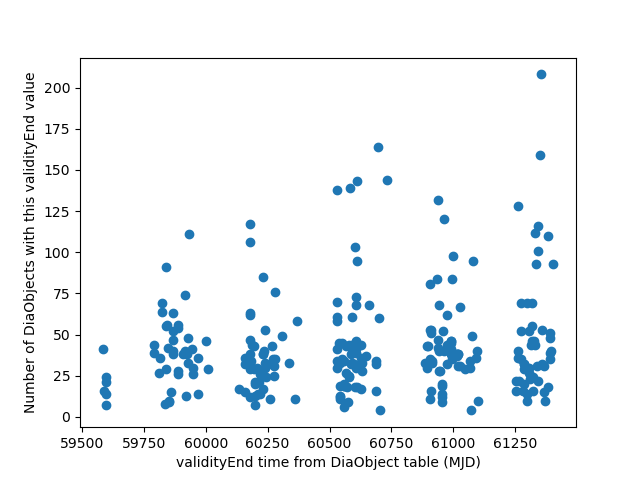

Text(0, 0.5, 'Number of DiaObjects with this validityEnd value')

In [87]:
plt.figure()
plt.plot(objTableAll.value_counts('validityEndMjd'), ls='None', marker='o')
plt.xlabel('validityEnd time from DiaObject table (MJD)')
plt.ylabel('Number of DiaObjects with this validityEnd value')

In [35]:
validityCounts = objTableAll.groupby('validityEnd').count()

In [36]:
validityCounts

,diaObjectId,validityStart,ra,raErr,decl,declErr,ra_decl_Cov,radecTai,pmRa,pmRaErr,...,yPSFluxMax,yPSFluxStetsonJ,yPSFluxLinearSlope,yPSFluxLinearIntercept,yPSFluxMaxSlope,yPSFluxErrMean,flags,lastNonForcedSource,nDiaSources,pixelId
validityEnd,,,,,,,,,,,,,,,,,,,,,
2022-01-04 03:00:04.425800,31,31,31,0,31,0,0,31,0,0,...,18,7,7,7,7,18,31,31,31,31
2022-01-09 02:17:35.366199,17,17,17,0,17,0,0,17,0,0,...,15,12,12,12,12,15,17,17,17,17
2022-01-18 01:56:41.529800,9,9,9,0,9,0,0,9,0,0,...,8,6,6,6,6,8,9,9,9,9
2022-01-18 02:01:15.158200,5,5,5,0,5,0,0,5,0,0,...,5,5,5,5,5,5,5,5,5,5
2022-01-18 02:20:52.704000,22,22,22,0,22,0,0,22,0,0,...,18,13,13,13,13,18,22,22,22,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-12-17 01:28:12.969800,41,41,41,0,41,0,0,41,0,0,...,24,17,17,17,17,24,41,41,41,41
2026-12-17 01:55:30.768000,44,44,44,0,44,0,0,44,0,0,...,24,20,20,20,20,24,44,44,44,44
2026-12-18 04:39:38.467100,49,49,49,0,49,0,0,49,0,0,...,31,22,22,22,22,31,49,49,49,49


<IPython.core.display.Javascript object>


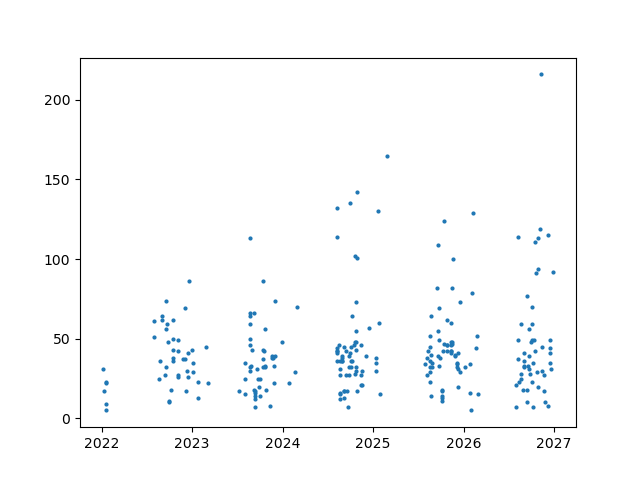

In [37]:
plt.figure()
plt.plot(validityCounts.index, validityCounts['diaObjectId'], ls='None', marker='o', ms='2')

In [3]:
#list(validityCounts.columns)